# Proposal 2

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import CTSV1
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/proposal_2.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [9]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "lambda_l1": [0.01, 0.1, 1.0, 10.0],
    "lambda_l2": [0.01, 0.1, 1.0, 10.0],
    "eps": [1e-8, 1e-5, 1e-2],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[CTSV1] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = CTSV1(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


Training model 1/48
Training model 2/48
Training model 3/48
Training model 4/48
Training model 5/48
Training model 6/48
Training model 7/48
Training model 8/48
Training model 9/48
Training model 10/48
Training model 11/48
Training model 12/48
Training model 13/48
Training model 14/48
Training model 15/48
Training model 16/48
Training model 17/48
Training model 18/48
Training model 19/48
Training model 20/48
Training model 21/48
Training model 22/48
Training model 23/48
Training model 24/48
Training model 25/48
Training model 26/48
Training model 27/48
Training model 28/48
Training model 29/48
Training model 30/48
Training model 31/48
Training model 32/48
Training model 33/48
Training model 34/48
Training model 35/48
Training model 36/48
Training model 37/48
Training model 38/48
Training model 39/48
Training model 40/48
Training model 41/48
Training model 42/48
Training model 43/48
Training model 44/48
Training model 45/48
Training model 46/48
Training model 47/48
Training model 48/48


In [10]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [11]:
best_hyperparameters

{'lambda_l1': 0.1, 'lambda_l2': 0.01, 'eps': 1e-05}

## Evaluation metrics definition

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [13]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [14]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = CTSV1(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 95.18it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 121.9000
	Loss_MB/train_phase/train_stream/Task000 = 1.8358
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.9281
100%|██████████| 469/469 [00:05<00:00, 92.94it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 124.0000
	Loss_MB/train_phase/train_stream/Task000 = 1.7526
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 5.0467
100%|██████████| 469/469 [00:04<00:00, 94.35it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 124.3000
	Loss_MB/train_phase/train_stream/Task000 = 1.2219
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.9713
100%|██████████| 469/469 [00:05<00:00, 92.60it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_stre

 10%|█         | 1/10 [00:36<05:29, 36.59s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.2097
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17706a0a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.3076
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [01:12<04:48, 36.11s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.2576
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x177353e20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.3076
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:48<04:13, 36.23s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5608
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x177a88610>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [02:25<03:39, 36.53s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.4711
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28bb23f40>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [03:00<03:00, 36.01s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6152
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28bcd1df0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.7681, 0.8501, 0.8954, 0.9051, 0.9381, 0.0822, 0.0819, 0.1122, 0.1232,
         0.1562],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [03:36<02:23, 35.85s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.0805
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28d881b20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.7681, 0.8501, 0.8954, 0.9051, 0.9381, 0.0822, 0.0819, 0.1122, 0.1232,
         0.1562],
        [0.7024, 0.7922, 0.8593, 0.9003, 0.9208, 0.9389, 0.0793, 0.1592, 0.1124,
         0.1195],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [04:11<01:46, 35.47s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7917
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28dbe7040>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.7681, 0.8501, 0.8954, 0.9051, 0.9381, 0.0822, 0.0819, 0.1122, 0.1232,
         0.1562],
        [0.7024, 0.7922, 0.8593, 0.9003, 0.9208, 0.9389, 0.0793, 0.1592, 0.1124,
         0.1195],
        [0.6675, 0.7120, 0.7772, 0.8744, 0.8576, 0.9236, 0.9406, 0.1292, 0.1112,
         0.1331],
    

 80%|████████  | 8/10 [04:46<01:10, 35.39s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6247
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x165f07760>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.7681, 0.8501, 0.8954, 0.9051, 0.9381, 0.0822, 0.0819, 0.1122, 0.1232,
         0.1562],
        [0.7024, 0.7922, 0.8593, 0.9003, 0.9208, 0.9389, 0.0793, 0.1592, 0.1124,
         0.1195],
        [0.6675, 0.7120, 0.7772, 0.8744, 0.8576, 0.9236, 0.9406, 0.1292, 0.1112,
         0.1331],
    

 90%|█████████ | 9/10 [05:23<00:35, 35.99s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.7935
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1661d4580>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.7681, 0.8501, 0.8954, 0.9051, 0.9381, 0.0822, 0.0819, 0.1122, 0.1232,
         0.1562],
        [0.7024, 0.7922, 0.8593, 0.9003, 0.9208, 0.9389, 0.0793, 0.1592, 0.1124,
         0.1195],
        [0.6675, 0.7120, 0.7772, 0.8744, 0.8576, 0.9236, 0.9406, 0.1292, 0.1112,
         0.1331],
    

100%|██████████| 10/10 [05:59<00:00, 35.97s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.7000
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x166251100>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2164.1719
	EvalStream/Acc_Matrix = 
tensor([[0.9089, 0.1410, 0.1369, 0.1352, 0.1327, 0.0894, 0.1190, 0.0855, 0.1006,
         0.1346],
        [0.8863, 0.9244, 0.1555, 0.1091, 0.1565, 0.0837, 0.1086, 0.0961, 0.1087,
         0.1622],
        [0.8618, 0.8965, 0.9347, 0.0971, 0.0977, 0.1079, 0.0837, 0.1301, 0.1079,
         0.1394],
        [0.8022, 0.8721, 0.9140, 0.9358, 0.0765, 0.0646, 0.0860, 0.1174, 0.0936,
         0.1379],
        [0.7681, 0.8501, 0.8954, 0.9051, 0.9381, 0.0822, 0.0819, 0.1122, 0.1232,
         0.1562],
        [0.7024, 0.7922, 0.8593, 0.9003, 0.9208, 0.9389, 0.0793, 0.1592, 0.1124,
         0.1195],
        [0.6675, 0.7120, 0.7772, 0.8744, 0.8576, 0.9236, 0.9406, 0.1292, 0.1112,
         0.1331],
    

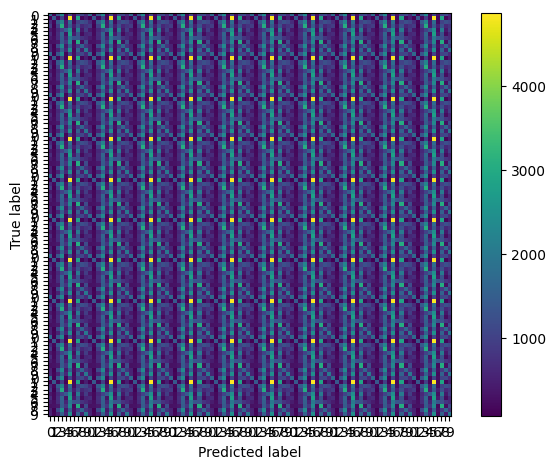

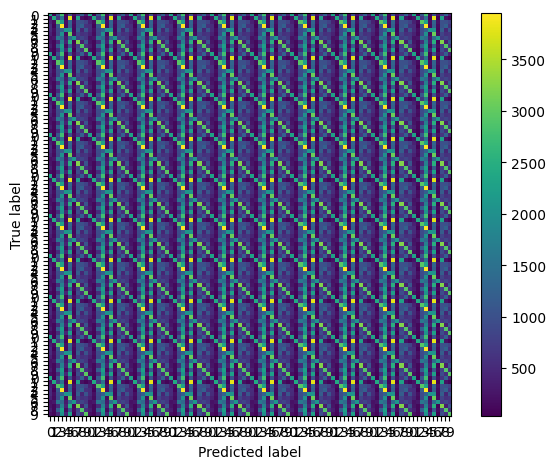

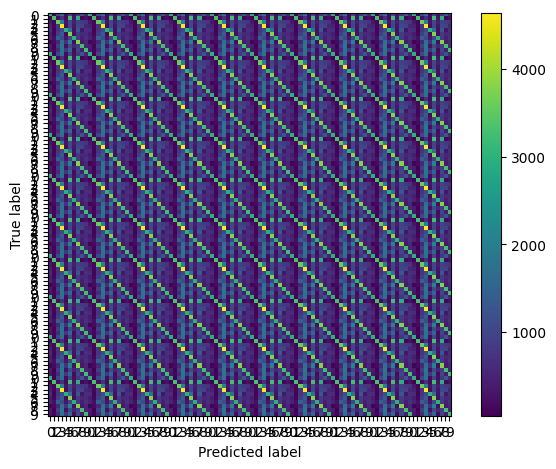

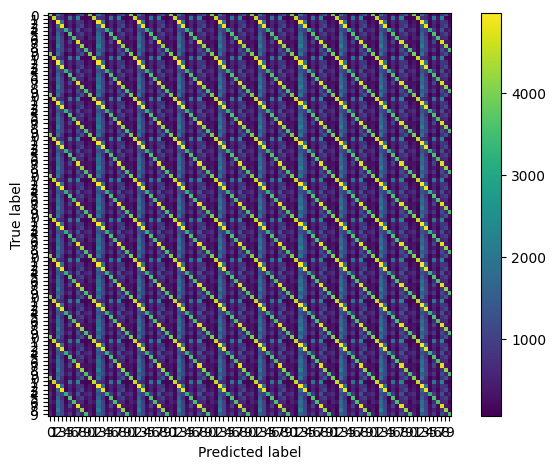

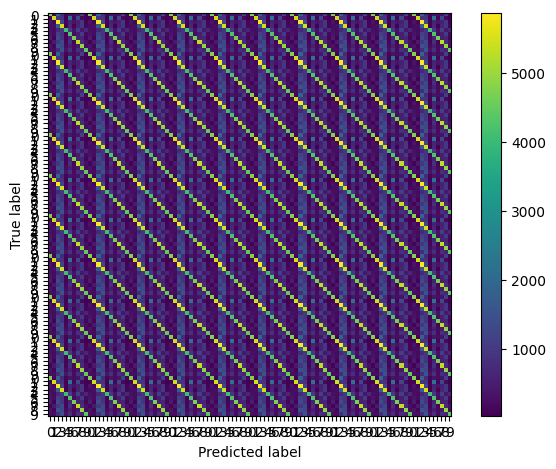

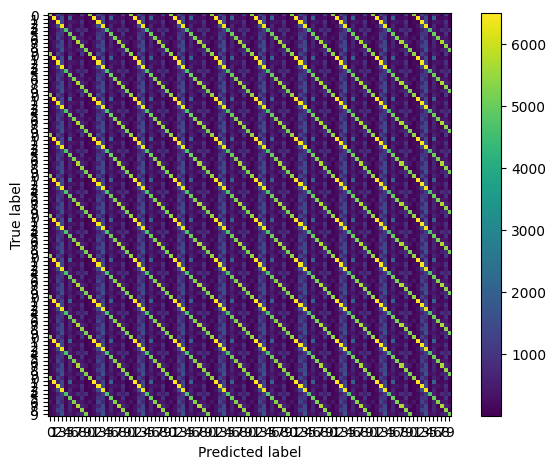

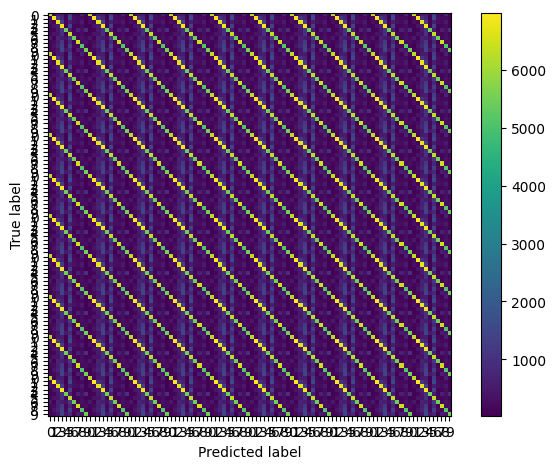

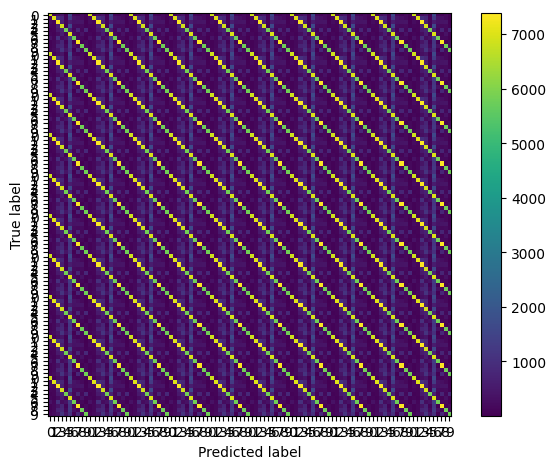

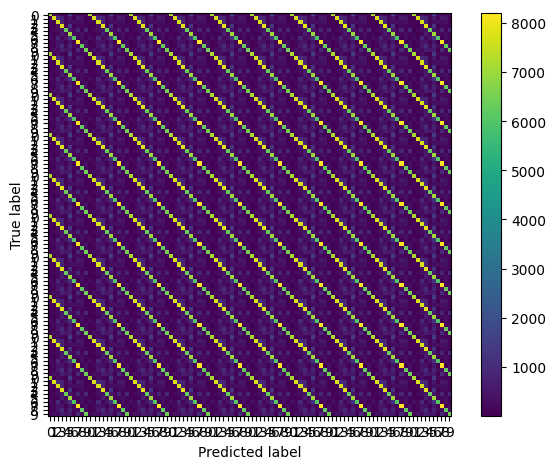

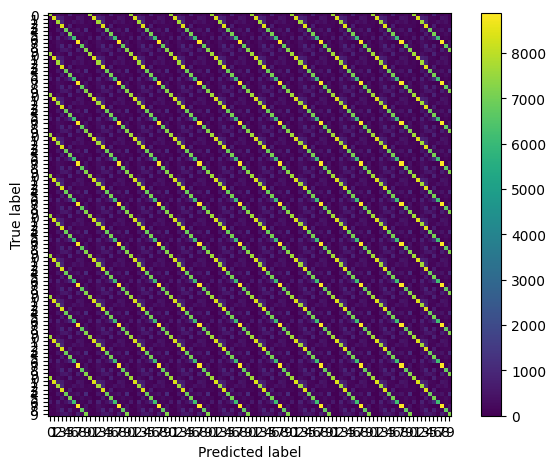

In [15]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [16]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [17]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [18]:
all_loss_components = strategy.get_store_loss()

In [19]:
weights = model_plugins[0].weights

# Store metrics

In [20]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))